# IMDB Sentiment Classification
The following code aims to use a vanilla RNN to classify movie reviews into "positive" and "negative" sentiments, with hyperparameter tuning to optimise results. 

## 1 - Library Imports
The first step is to import the required libraries:
- *ssl* to download the dataset 
- *tensorflow* for the neural network
- *keras_tuner* for hyperparameter tuning
- *matplotlib* for visualising the data in graphs


In [56]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models, layers, datasets
import ssl
import keras_tuner as kt
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

## 2 - Data Preprocessing
This step involves importing the dataset and padding the sequences so they are all the same length, unifying the input for the network.

In [210]:
ssl._create_default_https_context = ssl._create_unverified_context
(x_train, y_train), (x_test, y_test) = datasets.imdb.load_data(num_words=2000)

x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen = 256)
x_test = keras.preprocessing.sequence.pad_sequences(x_train, maxlen = 256)

In [82]:
print("Training Data: ", x_train.shape)
print("Testing Data: ", x_test.shape)

print("-"*50)
print("Sample Review")
print(x_train[0])
print("Review Sentiment: ", y_train[0])

Training Data:  (24992, 256)
Testing Data:  (24992, 256)
--------------------------------------------------
Sample Review
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    1   14   22   16
   43  530  973 1622 1385   65  458 4468   66 3941    4  173   36  256
    5   25  100   43  838  112   50  670    2    9   35  480  284    5
  150    4  172  112  167    2  336  385   39    4  172 4536 1111   17
  546   38   13  447    4  192   50   16    6  147 2025   19   14   22
    4 1920 4613  469    4   22   71   87   12   16   43  530   38   76
   15   13 1247    4   22   17  515   17   12   16  626   18    2    5
   62  386   12    8  316    8  106    5    4 2223 5244   16  480   66
 3785   33    4  130   12   16   38  619    5   25  124   51   36  135
   48   25 1415   33    6   22   12  215   28   77   52    5   14  407
   16   82    2    8    4 

## 3 - Model Building
The first step is to build the hypermodel, first beginning with a layer to embed data then running through a simple rnn layer. The first hyperparameter to tune is the learning rate, with three values to consider - 0.01, 0.001, 0.0001. The model is compiled with an adam optimizer and binary cross_entropy as the loss. 

In [119]:
def model_builder(hp):
    batch_size = 32

    model = models.Sequential()
    model.add(layers.Embedding(input_dim = 10000, output_dim = 128, input_length =10000))
    model.add(layers.SimpleRNN(1))

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                  loss = keras.losses.BinaryCrossentropy(from_logits = False), 
                  metrics = ['accuracy'])
    return model


Next, a hyperband tuner is built, with the objective to maximise validation accuracy.

In [120]:
tuner = kt.Hyperband(model_builder, objective = "val_accuracy")

Reloading Tuner from ./untitled_project/tuner0.json


Early stopping is then initialised to prevent overfitting the data.

In [121]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

Next, the hyperband tuner is run on the training data, using a 1:4 training to validation split, to obtain the optimal learning rate. 

In [122]:
tuner.search(x_train, y_train, epochs = 50, validation_split = 0.2, callbacks = [stop_early])

best_hps = tuner.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal learning rate for the optimizer
is 0.001.



Next, we train the model with the optimal learning rate that we obtained, to find the optimal number of epochs for which the model should be run. 

In [123]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs = 10, validation_split = 0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.5169 - loss: 3.7532 - val_accuracy: 0.5371 - val_loss: 3.1632
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.5783 - loss: 2.7882 - val_accuracy: 0.5481 - val_loss: 2.8384
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6203 - loss: 2.3437 - val_accuracy: 0.5471 - val_loss: 2.6270
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6459 - loss: 2.0613 - val_accuracy: 0.5519 - val_loss: 2.4824
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6595 - loss: 1.8367 - val_accuracy: 0.5501 - val_loss: 2.4057
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6682 - loss: 1.6568 - val_accuracy: 0.5515 - val_loss: 2.2624
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.6806 - loss: 1.4947 - val_accuracy: 0.5443 - val_loss: 2.0022
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.6856 - loss: 1.3212 - 

Finally, we create our model, with the number of epochs and the training data that lead to the optimal accuracy.

In [124]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.summary()
history = hypermodel.fit(x_train, y_train, epochs = best_epoch, validation_split = 0.2)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.5208 - loss: 3.8404 - val_accuracy: 0.5253 - val_loss: 3.5605
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.5886 - loss: 3.0825 - val_accuracy: 0.5449 - val_loss: 3.3951
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6261 - loss: 2.7083 - val_accuracy: 0.5489 - val_loss: 3.2747
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6470 - loss: 2.4635 - val_accuracy: 0.5495 - val_loss: 3.1464
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.6657 - loss: 2.3386 - val_accuracy: 0.5509 - val_loss: 3.1538
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6790 - loss: 2.2988 - val_accuracy: 0.5583 - val_loss: 3.1332
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.6858 - loss: 2.1902 - val_accuracy: 0.5629 - val_loss: 3.1047
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6925 - loss: 2.1137 - 

# 4 - Analysis & Results
To analyse the results, we first create a plot to show how the accuracy and loss varied with the number of epochs in both the calidation and the training data. 

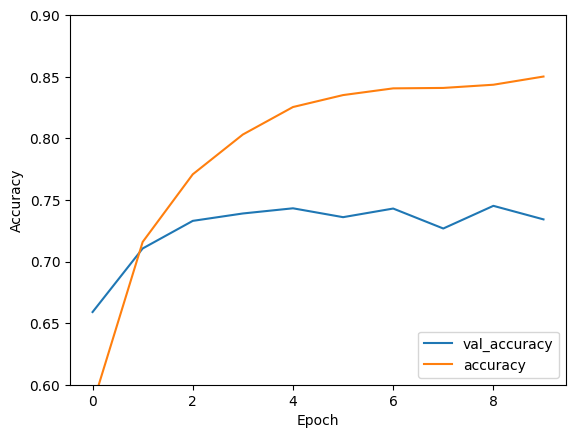

In [75]:
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.6, 0.9])
plt.legend(loc='lower right')

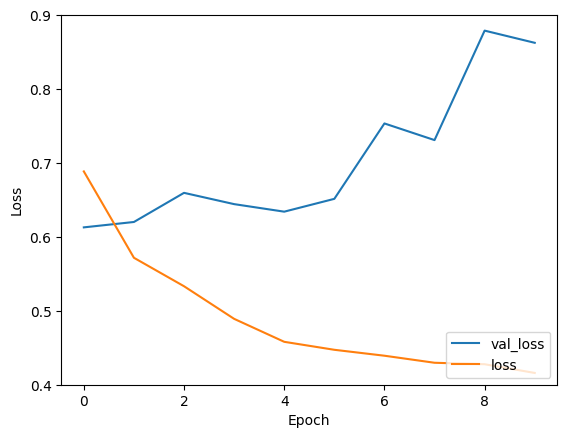

In [72]:
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.4, 0.9])
plt.legend(loc='lower right')

We then run the model on our testing data to see how well it performed. 

In [74]:
eval_result = hypermodel.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5010 - loss: 2.8975
[test loss, test accuracy]: [2.8974807262420654, 0.501039981842041]


## 5 - LSTMs
LSTMs are used to mitigate the issues related to exploding and vanishing gradients in Vanilla RNNs.

In [326]:
model = models.Sequential()
model.add(layers.Embedding(input_dim = 2000, output_dim = 32, input_length =256))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(32))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256,activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1,activation = 'sigmoid'))

model.compile(optimizer = keras.optimizers.Adam(), 
                loss = keras.losses.BinaryCrossentropy(from_logits = False), 
                metrics = ['accuracy'])


In [327]:
history = model.fit(x_train, y_train, epochs = 10, validation_split = 0.2)

Epoch 1/10


625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.7545 - loss: 0.4921 - val_accuracy: 0.8584 - val_loss: 0.3371
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.8583 - loss: 0.3395 - val_accuracy: 0.8656 - val_loss: 0.3300
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.8747 - loss: 0.2997 - val_accuracy: 0.7968 - val_loss: 0.4392
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.8880 - loss: 0.2738 - val_accuracy: 0.8744 - val_loss: 0.3088
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.8943 - loss: 0.2567 - val_accuracy: 0.8708 - val_loss: 0.3138
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9100 - loss: 0.2273 - val_accuracy: 0.8476 - val_loss: 0.4150
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9175 - loss: 0.2078 - val_accuracy: 0.8742 - val_loss: 0.3104
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9225 - loss: 0.1986 - val_accurac

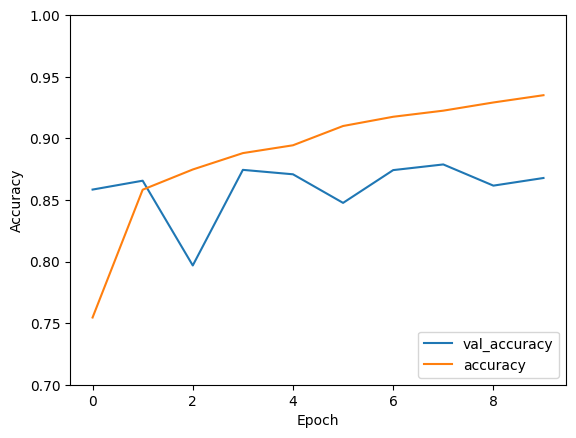

In [332]:
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1.0])
plt.legend(loc='lower right')

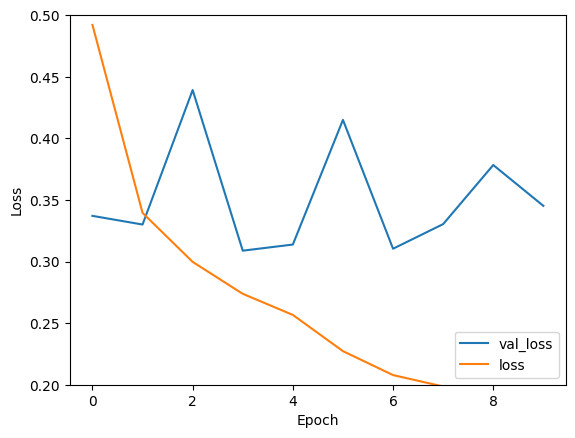

In [330]:
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.2, 0.5])
plt.legend(loc='lower right')

In [331]:
eval_result = model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4994 - loss: 2.2703
[test loss, test accuracy]: [2.270263910293579, 0.49935999512672424]
